# Titanic OGD assesment

### import libraries and data

In [33]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from lightgbm import LGBMClassifier


#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [2]:
# Run when on Collab
from google.colab import drive
drive.mount('/content/drive')
titanic_train = pd.read_csv("/content/drive/MyDrive/OGD/titanic-training-dataset.csv")
titanic_test = pd.read_csv("/content/drive/MyDrive/OGD/titanic-test-dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run when Local
titanic_train = pd.read_csv("/data/titanic-training-dataset.csv")
titanic_test = pd.read_csv("/data/titanic-test-dataset.csv")

## Cleanup and EDA
### Let's start off with some cleaning and exploritary data analysis

In [4]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some assumed explanation of the variables:

**PassengerID**: unique identifier for each passenger  
**Survived**: 1 means survived, 0 means dead  
**Pclass**: Which class is the passenger in?: 1st 2nd or 3rd  
**Name**: Name  
**Sex**: Only Male or Female as this was in 1912  
**Age**: Age  
**SibSp**: Number of sibling/spouses on board  
**Parch**: Number of parents/child on board  
**Ticket**: Ticket number  
**Fare**: Ticket price  
**Cabin**: Cabin number  
**Embarked**: Port of embarkation. A quick google search tells us that S: Southhampton, C: Cherbourg and Q: Queenstown (https://edition.cnn.com/2013/09/30/us/titanic-fast-facts/index.html)  


We're trying to decide whether a passenger with particular attributes will survive the Titanic disaster, so the **Survived** variable is our label, the other columns are the **features**. 

In [5]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We need to do some cleanup: 
 * Age has missing values. Let's assume that a person with missing age is of mean age.
 * Embarked has missing values, fill in with dominating embarkation point.
 * Convert the categorical values to numerical values.
 * Drop non-significant features

In [6]:
# Fill missing age values
titanic_train["Age"] = titanic_train["Age"].fillna(titanic_train["Age"].mean())
titanic_test["Age"] = titanic_test["Age"].fillna(titanic_test["Age"].mean())

In [7]:
# Check dominating embarkation point
titanic_train.groupby(['Embarked']).size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [8]:
# Fill missing embarkation points
titanic_train["Embarked"] = titanic_train["Embarked"].fillna('S')
titanic_test["Embarked"] = titanic_test["Embarked"].fillna('S')

In [9]:
# Sex to numeric 
def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic_train["Sex"] = titanic_train["Sex"].apply(sex_to_numeric)
titanic_test["Sex"] = titanic_test["Sex"].apply(sex_to_numeric)

In [10]:
# One-hot encode embarkation points
titanic_train = titanic_train.join(pd.get_dummies(titanic_train['Embarked']))
titanic_test = titanic_test.join(pd.get_dummies(titanic_test['Embarked']))

In [11]:
titanic_train.groupby(['Pclass', 'Cabin']).size()

Pclass  Cabin
1       A10      1
        A14      1
        A16      1
        A19      1
        A20      1
                ..
3       F E69    1
        F G63    1
        F G73    2
        F38      1
        G6       4
Length: 147, dtype: int64

It seems that almost only first class passengers have a cabin with the exception of 5 third class passengers (maybe mistake in administration). Without any context it's hard to extract information from the cabin number. So the only information we can work with is if a passenger has a cabin or not, but this can be confounded by the passenger class. So no valuable information from the cabin feature and it will thus be dropped.

Furthermore, let's work only with the numerical and categorical variables and also omit passengerID, Name, Ticket and Embarked. These values could contain some information, but it's hard to make sense of them without more context.

In [12]:
features_train = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "C", "Q", "S"]
features_test = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "C", "Q", "S"]
titanic_train = titanic_train[features_train]
titanic_test = titanic_test[features_test]

# So here I discoverd that the test set doesn't have the label Survived 
# which I found rather odd since the performance can't be evaluated this way.
# I will split the training data into train and test/validation data on a 80/20 split and evaluate the performance 

Now let's take a better look at our cleaned data

In [13]:
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [14]:
titanic_train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000


In [15]:
titanic_train.isnull().values.any()

False

In [16]:
titanic_train['C'] = titanic_train['C'].astype(np.int64)
titanic_train['Q'] = titanic_train['C'].astype(np.int64)
titanic_train['S'] = titanic_train['C'].astype(np.int64)
titanic_train.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
C             int64
Q             int64
S             int64
dtype: object

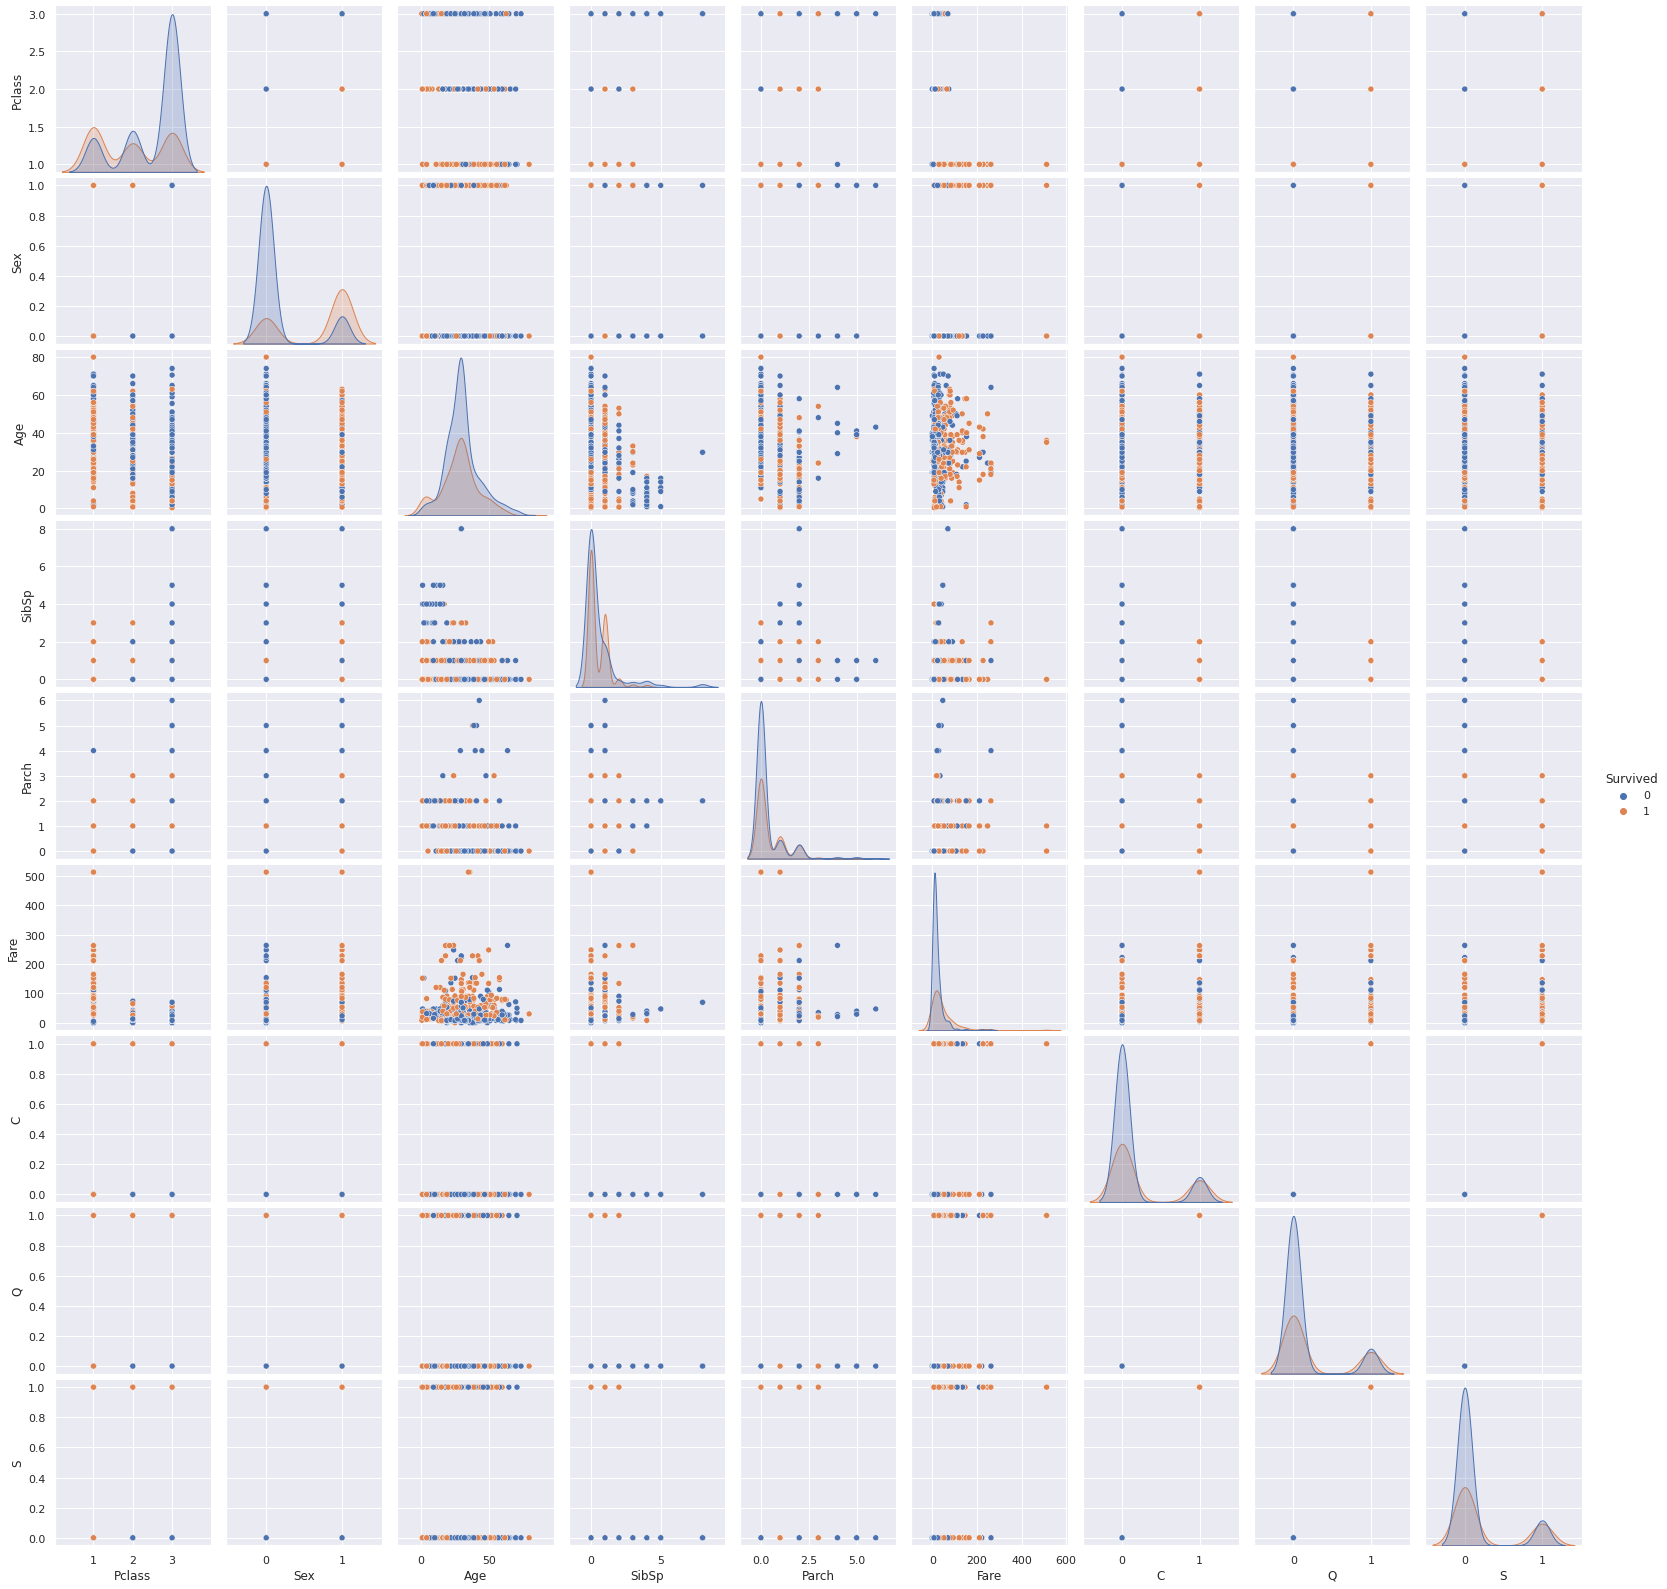

In [17]:
import seaborn as sns
sns.set()
sns.pairplot(titanic_train, hue="Survived");

Some noticable observations:
* People from lower passenger classes are more likely to die
* Woman are more likely to survive then men
* More likely to survive if you had more family on board
* Children and old people are more likely to survive 
* The continuous features age and fare appear to have good split points and spikes which can be benificial for decision tree based classifiers


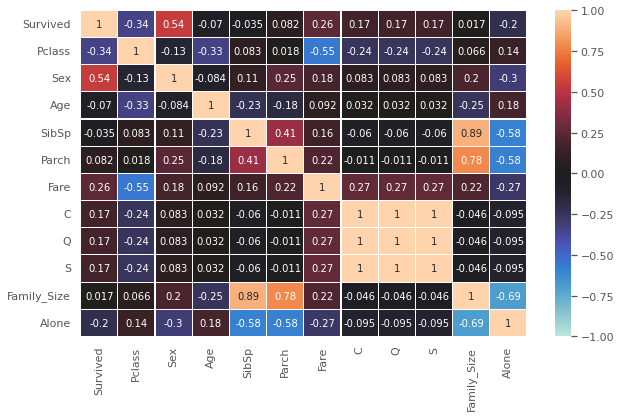

In [34]:
correlation = titanic_train.corr()
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, center=0, linewidths=0.1)


There appears to be some relation between variables.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


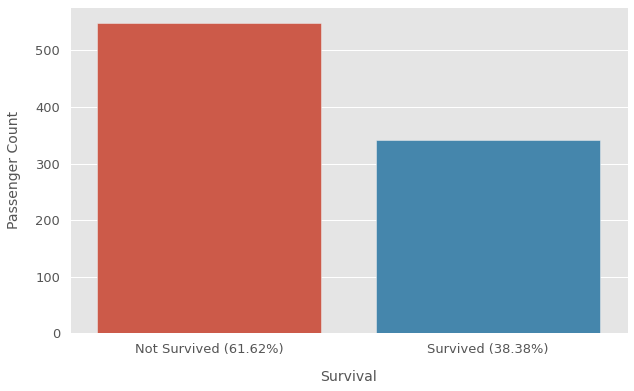

In [35]:
survived = titanic_train['Survived'].value_counts()[1] / titanic_train.shape[0] * 100
not_survived = titanic_train['Survived'].value_counts()[0] / titanic_train.shape[0] * 100

sns.countplot(titanic_train['Survived'])

plt.xlabel('Survival', size=14, labelpad=14)
plt.ylabel('Passenger Count', size=14, labelpad=14)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived), 'Survived ({0:.2f}%)'.format(survived)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)


plt.show()

With the features SibSp and Parch two new features can be created, namely Family_size and Alone. Now we can check if the family size has something to do with the survival rate. Let's do some visualization.

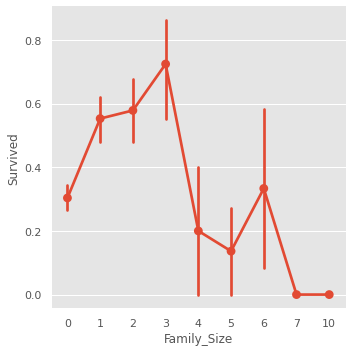

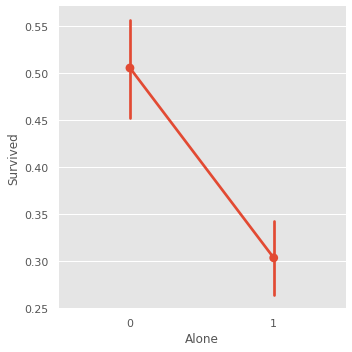

In [36]:
titanic_train['Family_Size']=0
titanic_train['Family_Size']=titanic_train['Parch']+titanic_train['SibSp']

titanic_train['Alone']=0
titanic_train.loc[titanic_train.Family_Size==0,'Alone']=1

sns.catplot(x ='Family_Size', y ='Survived', data = titanic_train, kind = 'point')
sns.catplot(x ='Alone', y ='Survived', data = titanic_train, kind = 'point')

The chance of survival seems to be increasing till a family size of 3 and dropping at 4. A logical reason for this could be that families may tend to stick together and have a harder time getting on a lifeboat when the familiy is big. Overall, travelling with a family increases the chance of survival rather then travelling alone.

## Modelling

In [21]:
# since the test data doesn't contain a label, the train data is split into train and test data

train, test = train_test_split(titanic_train, test_size=0.2, stratify=titanic_train['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

Three different classifiers will be evaluated:

1. Multinomial Naive Bayes (bag of words model)
2. Logistic Regression (regression model)
3. LightGBM (decision tree based model)

Since the data is somewhat imbalanced the metrics for evaluation will be the F1 score and the AUROC.

In [22]:
model = LogisticRegression(max_iter = 1000)
model.fit(train_X,train_Y.values.ravel())
prediction3=model.predict(test_X)

print('The F1-score of the Logistic Regression is',metrics.f1_score(prediction3,test_Y))

The F1-score of the Logistic Regression is 0.7313432835820897


In [23]:
probs = model.predict_proba(test_X)
preds = probs[:,1]
fprL, tprL, threshold = metrics.roc_curve(test_Y, preds)
roc_aucL = metrics.auc(fprL, tprL)

In [24]:
model = MultinomialNB()
model.fit(train_X,train_Y.values.ravel())
prediction3=model.predict(test_X)

print('The F1-score of the MNB is',metrics.f1_score(prediction3,test_Y))

The F1-score of the MNB is 0.5937500000000001


In [25]:
probs = model.predict_proba(test_X)
preds = probs[:,1]
fprM, tprM, threshold = metrics.roc_curve(test_Y, preds)
roc_aucM = metrics.auc(fprM, tprM)

In [26]:
model = LGBMClassifier()
model.fit(train_X,train_Y.values.ravel())
prediction3=model.predict(test_X)

print('The F1-score of the LGBM is',metrics.f1_score(prediction3,test_Y))

The F1-score of the LGBM is 0.759124087591241


In [27]:
probs = model.predict_proba(test_X)
preds = probs[:,1]
fprLG, tprLG, threshold = metrics.roc_curve(test_Y, preds)
roc_aucLG = metrics.auc(fprLG, tprLG)

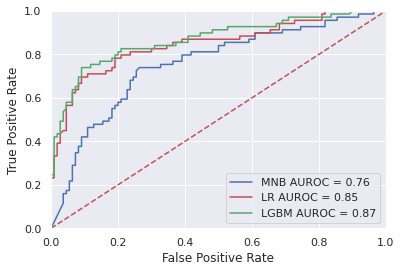

In [28]:
#plt.title('Receiver Operating Characteristic')
plt.plot(fprM, tprM, 'b', label = 'MNB AUROC = %0.2f' % roc_aucM)
plt.plot(fprL, tprL, 'r', label = 'LR AUROC = %0.2f' % roc_aucL)
plt.plot(fprLG, tprLG, 'g', label = 'LGBM AUROC = %0.2f' % roc_aucLG)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LGBM performs the best achieving an F1-score of 0.76 and an AUROC value of 0.87.

Let's look at the most important features.

In [29]:
feature_names = train_X.columns
coefs = model.feature_importances_

In [30]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
dfLGBM = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
dfLGBM["abs_value"] = dfLGBM["value"].apply(lambda x: abs(x))
dfLGBM["colors"] = dfLGBM["value"].apply(lambda x: "green" if x > 0 else "red")
dfLGBM = dfLGBM.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

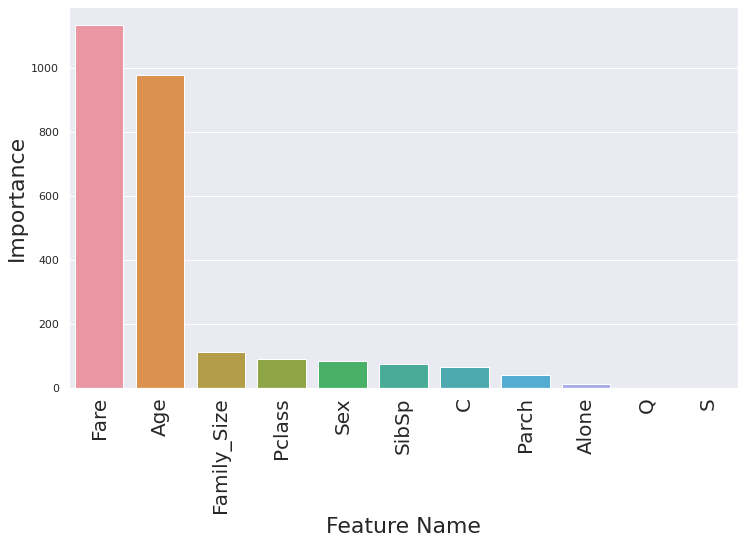

In [31]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=dfLGBM)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_ylabel("Importance", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

Fare and age seem to by far the most important features. After a steep drop in importance we find our engineered feature Family_size followed by Sex and Pclass. The most important things for survival seem to be: money, age, sex and family power....

![alt text](https://media4.giphy.com/media/YPSoRUvbMLthTTf7WE/200.gif "Title")



### TIME FOR AN API

In [32]:
model.booster_.save_model('/content/drive/MyDrive/OGD/model.txt')